In [1]:
%%file horizon.scons

g = 'grey crowd1=0.96 crowd2=0.85 wantaxis=n title="%s" '

# Seismic horizon
Fetch('horizon.asc','hall')
Flow('horizon','horizon.asc',
     '''
     echo in=$SOURCE data_format=ascii_float n1=3 n2=57036 | 
     dd form=native | window n1=1 f1=-1 | 
     put 
     n2=291 o2=35.031 d2=0.01 label2=y unit2=km 
     n1=196 o1=33.139 d1=0.01 label1=x unit1=km
     ''')

# Detrend
Flow('m1','horizon','math output=1')
Flow('m2','horizon','math output=x1 | scale axis=2')
Flow('m3','horizon','math output=x2 | scale axis=2')
Flow('flt trend','m1 m2 m3 horizon',
     '''
     cat ${SOURCES[1:3]} | 
     lpf match=${SOURCES[3]} pred=${TARGETS[1]}
     rect1=1000 rect2=1000 
     ''')
Flow('horizon2','horizon trend','add scale=1,-1 ${SOURCES[1]}')

Result('horizon2',g % '(a) Training Image')

Writing horizon.scons


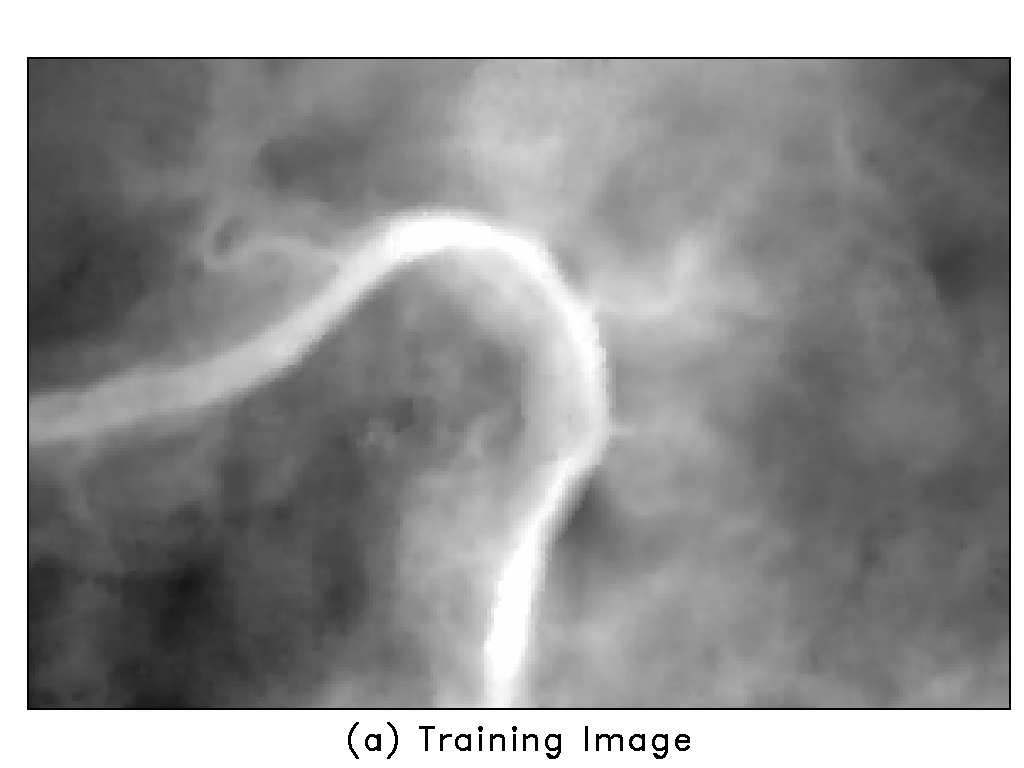

In [2]:
from m8r import view
view('horizon2')

In [3]:
%%file pef.scons

# Estimate PEF
Flow('pef lag','horizon2','hpef niter=50 a=10,10 lag=${TARGETS[1]}')

# PEF residual
Flow('res','horizon2 pef','helicon filt=${SOURCES[1]}')
Result('res',g % '(b) Training Image * PEF')

Writing pef.scons


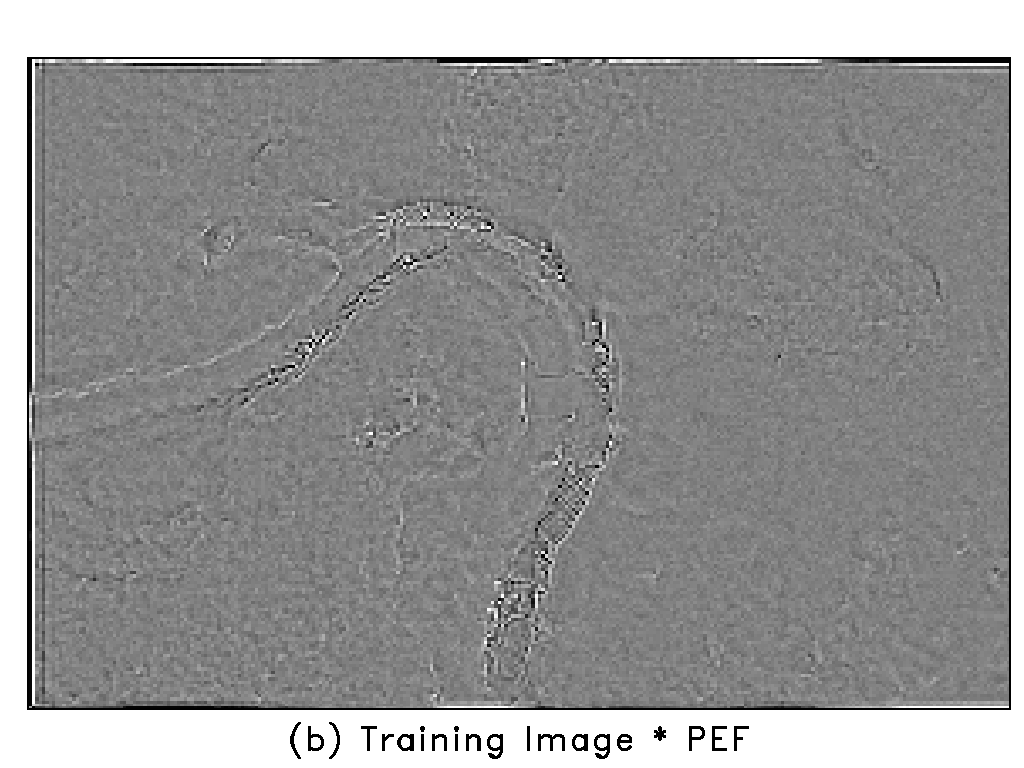

In [4]:
view('res')

In [5]:
%%file pattern.scons

# Synthesized image
Flow('syn','horizon2 pef',
     '''
     noise rep=y seed=2018 | 
     helicon filt=${SOURCES[1]} div=y
     ''')
Result('syn',g % '(c) Random Numbers / PEF')

Writing pattern.scons


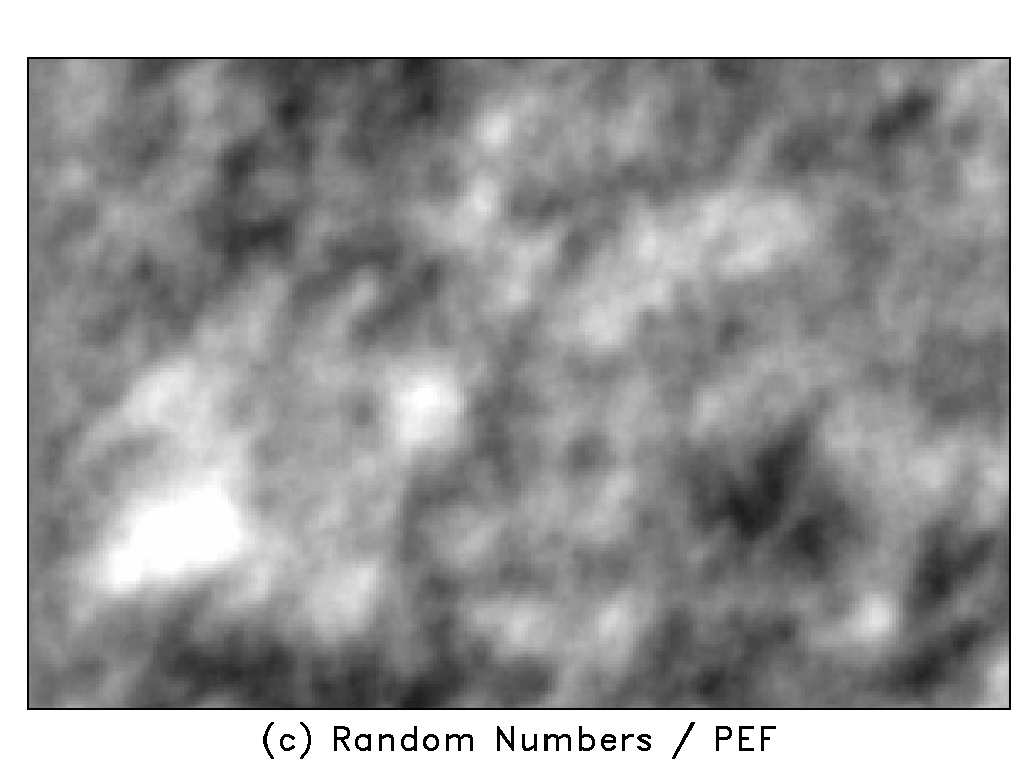

In [6]:
view('syn')

In [25]:
%%file npef.scons

# Non-stationary PEF
Flow('npef','horizon2',
     'apef a=10,10 rect1=10 rect2=10 niter=100 jump=1 verb=y')

# Non-stationary PEF residual
Flow('nres','horizon2 npef','nmult filt=${SOURCES[1]}')
Result('nres',g % '(b) Training Image * NPEF')

Overwriting npef.scons


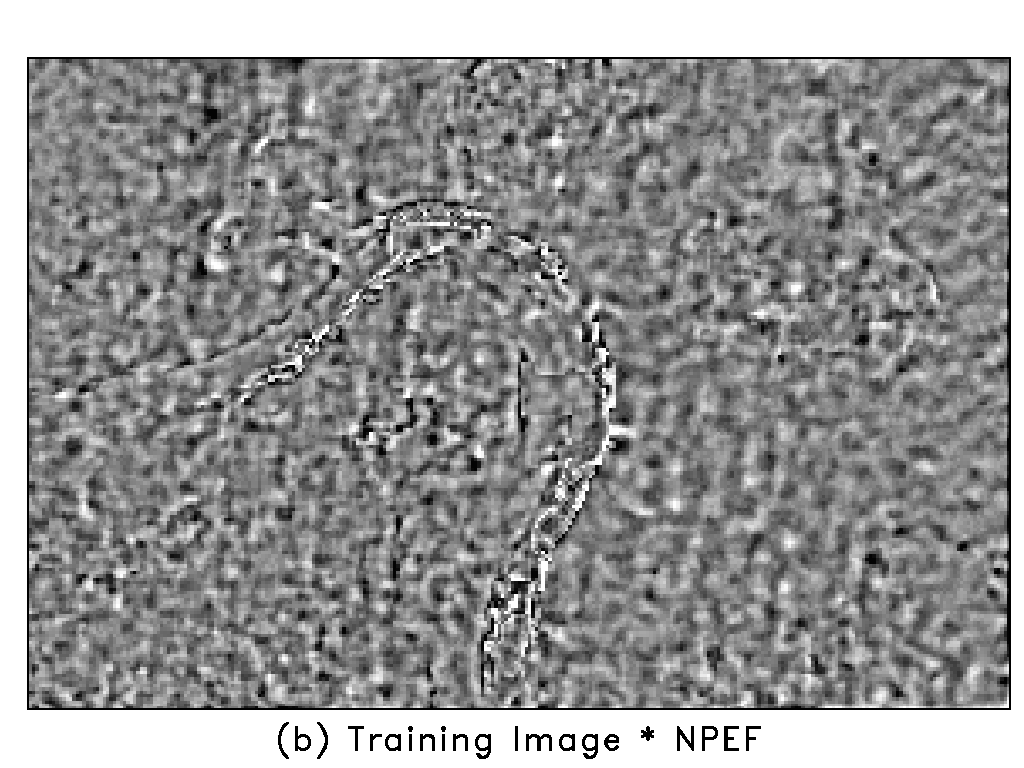

In [26]:
view('nres')

In [22]:
!sfdottest sfnmult filt=npef.rsf mod=horizon.rsf dat=horizon.rsf

sfdottest: L'[d]*m=13.493
sfdottest:  L[m]*d=13.493


In [33]:
%%file inverse.scons

Flow('noise','horizon2','noise rep=y mean=0 var=0.05 seed=2018')
Flow('npat','noise npef',
     '''
     conjgrad nmult filt=${SOURCES[1]} mod=${SOURCES[0]} niter=200 
     ''')
Result('npat',g % '(c) Random Numbers / NPEF')

Overwriting inverse.scons


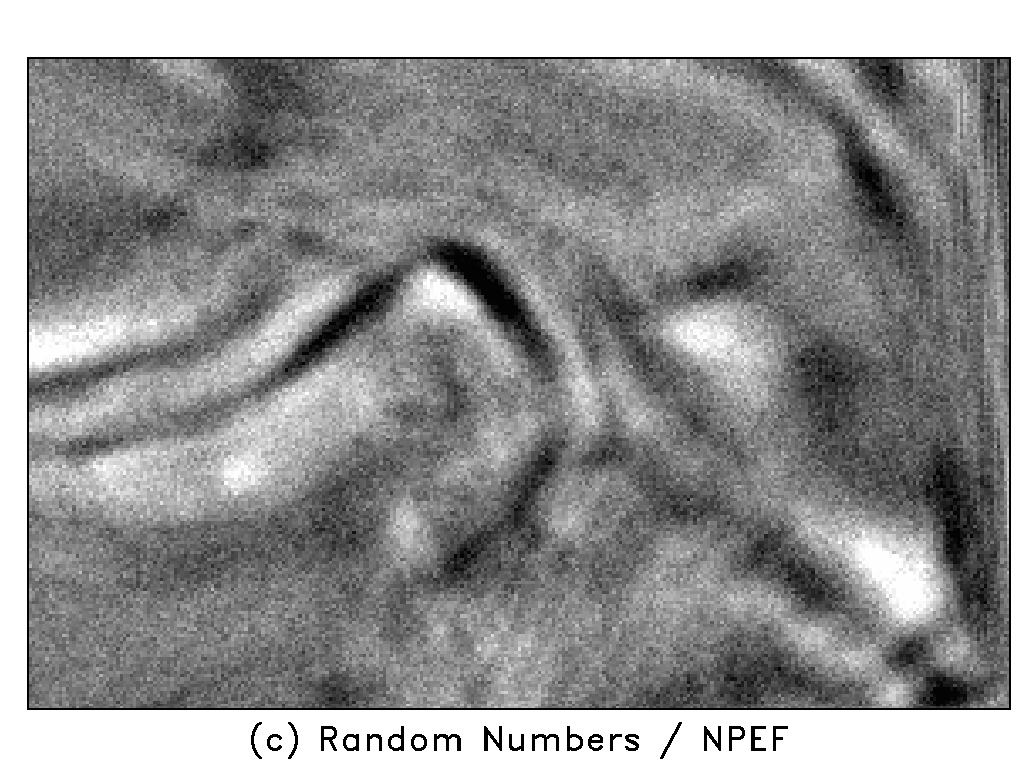

In [34]:
view('npat')